<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#EmoInt-dataset-for-emotion-detection-in-lyrics" data-toc-modified-id="EmoInt-dataset-for-emotion-detection-in-lyrics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>EmoInt dataset for emotion detection in lyrics</a></span><ul class="toc-item"><li><span><a href="#EmoInt-statistics" data-toc-modified-id="EmoInt-statistics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>EmoInt statistics</a></span></li><li><span><a href="#Merge-with-MoodyLyrics" data-toc-modified-id="Merge-with-MoodyLyrics-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Merge with MoodyLyrics</a></span></li></ul></li><li><span><a href="#Features-Selection" data-toc-modified-id="Features-Selection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Features Selection</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#k-Nearest-Neighbour" data-toc-modified-id="k-Nearest-Neighbour-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>k-Nearest Neighbour</a></span></li><li><span><a href="#SVM" data-toc-modified-id="SVM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>SVM</a></span></li><li><span><a href="#Gradient-Boost" data-toc-modified-id="Gradient-Boost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gradient Boost</a></span></li><li><span><a href="#Artificial-Neural-Network" data-toc-modified-id="Artificial-Neural-Network-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Artificial Neural Network</a></span></li><li><span><a href="#Naive-Bayes-Classifier" data-toc-modified-id="Naive-Bayes-Classifier-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Naive Bayes Classifier</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li></ul></div>

In [5]:
import spacy
import os
import sys

import itertools

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from utils.datasets import load_dataset_from_path, split_train_validation

emotion_labels = ['happy', 'sad', 'angry', 'relaxed']

In [6]:
def plot_confusion_matrix(cm, classes = emotion_labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# EmoInt dataset for emotion detection in lyrics

Existing emotion datasets are mainly annotated categorically without an indication of degree of emotion. EmoInt, instead, provides several tweets annotated according to an emotion (anger, fear, joy, sadness) and to the degree at which the emotion is expressed in text.

It is important to mention that EmoInt was manually annotated, using [Best-Worst Scaling](https://nparc.nrc-cnrc.gc.ca/eng/view/fulltext/?id=b132b0af-2ae0-4964-ac3a-493e7292a37a) (BWS), an annotation scheme shown to obtain very reliable scores.

For our purpose, we will consider each tweet to be like a lyric and, on top of that, we will perform our feature engineering using spaCy and the other tools we used so far.

Our original dataset, MoodyLyrics, contains "happy", "sad", "angry" and "relaxed" as labels. Therefore, in order to perform a sort of interjection with EmoInt, we will just use the tweets corresponding to the anger, joy and sadness emotions.

The remaining part of this notebook assumes that we have already parsed EmoInt dataset in a .csv file which we can use to train some machine learning models as we did when we performed our feature engineering on lyrics. For more information about how this .csv was generated, please refer to the `src/emoint_parser.py` script.

## EmoInt statistics

As EmoInt provide intensity levels together with emotion labels, we decided to take into account only those tweets for which the intensity was greater that 0.50 (50%). Also, we dropped hashtags a remove the tag characters (e.g. "Hey @MrTwitter how are you? #cool" became "Hey MrTwitter how are you?") because we will have to compare those tweets with songs and songs do not have those kind of things. Also, this sort of preprocessing should maximize the chances that everything is recognized properly by spaCy's POS tagger.

In [7]:
emoint = pd.read_csv('datasets/emoint_featurized.csv')

In [8]:
useless_columns = [ 'ID','ARTIST', 'SONG_TITLE', 'X_FREQUENCIES', 'SPACE_FREQUENCIES']
emoint.drop(useless_columns, axis=1, inplace=True)

In [9]:
emoint.head(5)

,LYRICS_VECTOR,TITLE_VECTOR,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,IS_TITLE_IN_LYRICS,RHYMES,VERB_PRESENT,...,NOUN_FREQUENCIES,NUM_FREQUENCIES,PART_FREQUENCIES,PRON_FREQUENCIES,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES,EMOTION
0,[-1.26710683e-01 1.60194725e-01 -1.36762261e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,16,0.0,0.000000,0.0,False,0.0,0.750000,...,0.062500,0.0,0.000000,0.000000,0.125000,0.187500,0.0,0.0,0.250000,happy
1,[-6.28133714e-02 1.90393195e-01 -1.95530921e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,19,0.0,1.000000,0.0,False,0.0,0.666667,...,0.157895,0.0,0.000000,0.105263,0.000000,0.052632,0.0,0.0,0.263158,happy
2,[ 9.66307223e-02 2.91245524e-02 -1.42218113e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,11,0.0,0.000000,0.0,False,0.0,0.500000,...,0.545455,0.0,0.000000,0.000000,0.363636,0.000000,0.0,0.0,0.181818,happy
3,[-1.13483094e-01 3.13860744e-01 -2.05740720e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,23,0.0,0.200000,0.0,False,0.0,0.750000,...,0.086957,0.0,0.000000,0.217391,0.043478,0.304348,0.0,0.0,0.173913,happy
4,[ 3.85632203e-03 2.41273686e-01 -1.58885673e-...,[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...,1,22,0.0,0.666667,0.0,False,0.0,1.000000,...,0.272727,0.0,0.045455,0.136364,0.045455,0.136364,0.0,0.0,0.227273,happy


We used the same columns naming convention we used in the past notebooks with MoodyLyrics just for compatibility reasons (we will have to put them together). Since tweets do not have title, the `TITLE_VECTOR` was just left there as a vector of 0s, with the same shape of the `LYRICS_VECTOR`.

## Merge with MoodyLyrics
Let's now merge EmoInt and MoodyLyrics featurized datasets in order to be able to proceed with further analysis.

In [10]:
path = 'datasets/moodylyrics_featurized.csv'

In [11]:
moodylyrics = pd.read_csv(path)
moodylyrics.columns = ['ID', 'ARTIST', 'SONG_TITLE', 'LYRICS_VECTOR', 'TITLE_VECTOR', 
                   'LINE_COUNT', 'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
                   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'RHYMES', 'VERB_PRESENT', 
                   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES', 'CONJUCTION_FREQUENCIES', 
                   'ADV_FREQUENCIES', 'AUX_FREQUENCIES', 'CONJ_FREQUENCIES', 'CCONJ_FREQUENCIES', 
                   'DETERMINER_FREQUENCIES', 'INTERJECTION_FREQUENCIES', 'NOUN_FREQUENCIES', 
                   'NUM_FREQUENCIES', 'PART_FREQUENCIES', 'PRON_FREQUENCIES', 'PROPN_FREQUENCIES', 
                   'PUNCT_FREQUENCIES', 'SCONJ_FREQUENCIES', 'SYM_FREQUENCIES', 'VERB_FREQUENCIES', 
                   'X_FREQUENCIES', 'SPACE_FREQUENCIES', 'EMOTION']
moodylyrics.drop(useless_columns, axis=1, inplace=True)

In [12]:
dataset = emoint.append(moodylyrics)

In [13]:
dataset.describe()

,LINE_COUNT,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,RHYMES,VERB_PRESENT,VERB_PAST,VERB_FUTURE,ADJ_FREQUENCIES,...,INTERJECTION_FREQUENCIES,NOUN_FREQUENCIES,NUM_FREQUENCIES,PART_FREQUENCIES,PRON_FREQUENCIES,PROPN_FREQUENCIES,PUNCT_FREQUENCIES,SCONJ_FREQUENCIES,SYM_FREQUENCIES,VERB_FREQUENCIES
count,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,...,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.000000,4706.0,4706.000000,4706.000000
mean,18.771143,115.487675,0.001933,0.257160,0.046589,0.034445,0.681493,0.223661,0.032797,0.103892,...,0.014189,0.190628,0.007121,0.025846,0.118723,0.046162,0.097045,0.0,0.001023,0.235702
std,21.636621,123.785535,0.014999,0.307920,0.062358,0.076869,0.327669,0.276698,0.102555,0.080279,...,0.031877,0.105343,0.023027,0.035716,0.085248,0.092595,0.128123,0.0,0.013569,0.104105
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.051323,...,0.000000,0.127972,0.000000,0.000000,0.055556,0.000000,0.016854,0.0,0.000000,0.178571
50%,11.000000,64.000000,0.000000,0.142857,0.000000,0.000000,0.769231,0.125000,0.000000,0.090909,...,0.000000,0.178983,0.000000,0.011205,0.114544,0.002660,0.068182,0.0,0.000000,0.241379
75%,33.000000,198.000000,0.000000,0.451455,0.086786,0.031250,1.000000,0.333333,0.000000,0.142857,...,0.013502,0.240000,0.000000,0.041301,0.173913,0.060647,0.135135,0.0,0.000000,0.295567
max,188.000000,1149.000000,0.341463,1.000000,1.000000,0.735294,1.000000,1.000000,1.000000,0.666667,...,0.400000,1.000000,0.444444,0.333333,0.500000,1.500000,2.777778,0.0,0.714286,1.000000


# Features Selection

Based on our experience with previous models and feature engineering strategies, we believe that building models using all our available features is a waste of time. We already noticed that the models which achieved better results were those using just the content of the lyrics. Therefore we will work on just the content of our input texts (either lyrics or tweets) plus some additional features. Among all the available features we decided to pick the followings:
- SELFISH_DEGREE
- VERB_PRESENT
- VERB_PAST
- VERB_FUTURE

In fact we believe that we can not use other features which may seem to be useful for our purpose ,e.g. "RHYMES", because, as we are considering a broader dataset, those kind of features are not general enough (not suitable for tweets).

In [14]:
selected_columns = [
   'LYRICS_VECTOR',
   'WORD_COUNT', 'ECHOISMS', 'SELFISH_DEGREE', 
   'DUPLICATE_LINES', 'IS_TITLE_IN_LYRICS', 'VERB_PRESENT', 
   'VERB_PAST', 'VERB_FUTURE', 'ADJ_FREQUENCIES',
   'PUNCT_FREQUENCIES', 'EMOTION'
]
dataset = dataset[selected_columns]

In [15]:
dataset.head(5)

,LYRICS_VECTOR,WORD_COUNT,ECHOISMS,SELFISH_DEGREE,DUPLICATE_LINES,IS_TITLE_IN_LYRICS,VERB_PRESENT,VERB_PAST,VERB_FUTURE,ADJ_FREQUENCIES,PUNCT_FREQUENCIES,EMOTION
0,[-1.26710683e-01 1.60194725e-01 -1.36762261e-...,16,0.0,0.000000,0.0,False,0.750000,0.250000,0.0,0.062500,0.187500,happy
1,[-6.28133714e-02 1.90393195e-01 -1.95530921e-...,19,0.0,1.000000,0.0,False,0.666667,0.333333,0.0,0.105263,0.052632,happy
2,[ 9.66307223e-02 2.91245524e-02 -1.42218113e-...,11,0.0,0.000000,0.0,False,0.500000,0.500000,0.0,0.000000,0.000000,happy
3,[-1.13483094e-01 3.13860744e-01 -2.05740720e-...,23,0.0,0.200000,0.0,False,0.750000,0.250000,0.0,0.173913,0.304348,happy
4,[ 3.85632203e-03 2.41273686e-01 -1.58885673e-...,22,0.0,0.666667,0.0,False,1.000000,0.000000,0.0,0.090909,0.136364,happy


# Modeling

Before starting we should flatten the dataset's features which are vectors at the moment (title vector and content vector). Let's do that

In [16]:
X_vect = list()
for (i, row) in dataset.drop('EMOTION', axis=1).iterrows():
    sub_list = list()
    for field in row:
        if type(field) == str:
            field = field[1:-1].split()
            sub_list += [float(x.replace('\n','')) for x in field]
        else:
            sub_list.append(field)
    X_vect.append(np.array(sub_list))
X_vect = np.array(X_vect)

In [17]:
y = dataset.EMOTION.astype("category").cat.codes

In [18]:
print(X_vect.shape)
print(y.shape)

(4706, 310)
(4706,)


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

As we can see, we will have 4706 entries in our dataset, each of them having 304 different features.

## k-Nearest Neighbour

In [19]:
from sklearn.neighbors import KNeighborsClassifier

ks = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

for k in ks:
    # Build model
    clf = KNeighborsClassifier(n_neighbors=k, algorithm='auto', 
                           metric='euclidean', n_jobs=-1)
    # Evaluate accuracy
    scores = cross_val_score(clf, X_vect, y, cv=10)
    print('Accuracy for k=%d: %0.2f (+/- %0.2f)' % (k, scores.mean(), scores.std() * 1.96))

Accuracy for k=1: 0.44 (+/- 0.11)
Accuracy for k=3: 0.43 (+/- 0.09)
Accuracy for k=5: 0.43 (+/- 0.09)
Accuracy for k=7: 0.42 (+/- 0.10)
Accuracy for k=9: 0.42 (+/- 0.13)
Accuracy for k=11: 0.42 (+/- 0.13)
Accuracy for k=13: 0.41 (+/- 0.13)
Accuracy for k=15: 0.40 (+/- 0.14)
Accuracy for k=17: 0.41 (+/- 0.14)
Accuracy for k=19: 0.40 (+/- 0.15)
Accuracy for k=21: 0.40 (+/- 0.16)


## SVM

In [19]:
def parameters_grid_search(classifier, params, x, y, cv=10, verbose=False):
    """
    Grid Search to find best parameters for a certain classifier whose
    performances are evaluated using cross-validation
    """
    gs = GridSearchCV(classifier(), params, cv=cv, n_jobs=-1, verbose=verbose)
    gs.fit(x, y)    
    return (gs.best_estimator_, gs.best_params_, gs.best_score_)

In [20]:
from sklearn.svm import SVC

In [20]:
# Build model
clf = SVC()
# Define the set of parameters we want to test on
params = [
    { 'kernel': ['rbf'], 'C': [ 1 ] }
]

# Perform grid search
svm_best, best_params, best_score = parameters_grid_search(SVC, params, X_vect, y, verbose=1)
print('Parameters:', best_params)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.2min finished


Parameters: {'kernel': 'rbf', 'C': 1}


In [21]:
scores = cross_val_score(svm_best, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.54 (+/- 0.08)


In [23]:
svm = SVC(C=1, kernel='rbf')
svm.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

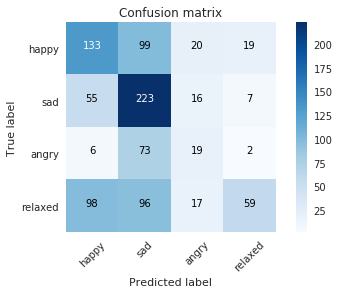

In [25]:
y_pred = svm.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))

## Gradient Boost

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

# Build model
clf = GradientBoostingClassifier(learning_rate=0.7, n_estimators=200)
# Evaluate accuracy
scores = cross_val_score(clf, X_vect, y, cv=10)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 1.96))

Accuracy: 0.76 (+/- 0.10)


## Artificial Neural Network

In [25]:
from sklearn.preprocessing import LabelEncoder

#1 Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size = 0.2, random_state = 0)

#2 y_nn should be a vector (len(X_vect),4), with a 1 in the right class
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_Y = encoder.transform(y_train)
y_nn = np_utils.to_categorical(encoded_Y)

#3 Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# we need to scale because we don't want one feature to predomine the others
# Standardize features by removing the mean and scaling to unit variance
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
#1 Importing the Keras libraries and packages
import keras
# Sequential module is required to initialize our ANN
from keras.models import Sequential
# Dense module is required to create the layers
from keras.layers import Dense, Dropout
    
def build_ann(optimizer='adam', input_size=X_vect.shape[1]):
    classifier = Sequential()
    #2 Adding first hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
    
    #2 Adding second hidden layer
    classifier.add(Dense(units = 60, kernel_initializer = 'random_normal', activation = 'sigmoid', input_dim = input_size))
    classifier.add(Dropout(0.5))
   

    # Adding output layer
    classifier.add(Dense(units = 4, kernel_initializer = 'random_normal', activation = 'softmax'))

    #3 Compiling the ANN
    classifier.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return classifier

In [33]:
classifier = build_ann('adam')
classifier.fit(X_train, y_nn, batch_size = 256, epochs = 300, verbose=True)
y_pred = classifier.predict(X_test)


y_pred1 = np.argmax(y_pred,axis=1)

encoder = LabelEncoder()
encoder.fit(y_test)
encoded_Y = encoder.transform(y_test)
y_nn_pred = np_utils.to_categorical(encoded_Y)

Epoch 1/300
3764/3764 [==============================] - 1s 308us/step - loss: 1.3520 - acc: 0.3127
Epoch 2/300
3764/3764 [==============================] - 0s 29us/step - loss: 1.3255 - acc: 0.3398
Epoch 3/300
3764/3764 [==============================] - 0s 47us/step - loss: 1.3031 - acc: 0.3882
Epoch 4/300
3764/3764 [==============================] - 0s 37us/step - loss: 1.2691 - acc: 0.4485
Epoch 5/300
3764/3764 [==============================] - 0s 29us/step - loss: 1.1969 - acc: 0.5197
Epoch 6/300
3764/3764 [==============================] - 0s 27us/step - loss: 1.1203 - acc: 0.5584
Epoch 7/300
3764/3764 [==============================] - 0s 26us/step - loss: 1.0344 - acc: 0.5882
Epoch 8/300
3764/3764 [==============================] - 0s 28us/step - loss: 0.9709 - acc: 0.6079
Epoch 9/300
3764/3764 [==============================] - 0s 24us/step - loss: 0.9262 - acc: 0.6124
Epoch 10/300
3764/3764 [==============================] - 0s 26us/step - loss: 0.8768 - acc: 0.6469
Epoch 11

3764/3764 [==============================] - 0s 21us/step - loss: 0.4000 - acc: 0.8491
Epoch 84/300
3764/3764 [==============================] - 0s 22us/step - loss: 0.4115 - acc: 0.8456
Epoch 85/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.3946 - acc: 0.8475
Epoch 86/300
3764/3764 [==============================] - 0s 21us/step - loss: 0.4020 - acc: 0.8510
Epoch 87/300
3764/3764 [==============================] - 0s 21us/step - loss: 0.4079 - acc: 0.8433
Epoch 88/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.3985 - acc: 0.8571
Epoch 89/300
3764/3764 [==============================] - 0s 24us/step - loss: 0.4008 - acc: 0.8520
Epoch 90/300
3764/3764 [==============================] - 0s 27us/step - loss: 0.3915 - acc: 0.8531
Epoch 91/300
3764/3764 [==============================] - 0s 25us/step - loss: 0.3912 - acc: 0.8512
Epoch 92/300
3764/3764 [==============================] - 0s 24us/step - loss: 0.3945 - acc: 0.8515
Epoch 93/300


3764/3764 [==============================] - 0s 20us/step - loss: 0.2418 - acc: 0.9123
Epoch 246/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2440 - acc: 0.9097
Epoch 247/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2433 - acc: 0.9139
Epoch 248/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2522 - acc: 0.9022
Epoch 249/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2507 - acc: 0.9025
Epoch 250/300
3764/3764 [==============================] - 0s 19us/step - loss: 0.2501 - acc: 0.9070
Epoch 251/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2489 - acc: 0.9054
Epoch 252/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2448 - acc: 0.9062
Epoch 253/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2307 - acc: 0.9158
Epoch 254/300
3764/3764 [==============================] - 0s 20us/step - loss: 0.2530 - acc: 0.9097
Epoc

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred1, y_nn_pred.argmax(axis=1))
accuracy = (sum([cm[i,i] for i in range(len(cm))])) / len(y_nn_pred)
print('Accuracy: %0.2f' % (accuracy*100))

Accuracy: 85.35


## Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
clf = GaussianNB()
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred))
print('Accuracy of Naive-Bayes classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

In [ ]:
y_pred = clf.predict(X_test_extra)
plot_confusion_matrix(confusion_matrix(y_test, y_pred_extra))
print('Accuracy of Naive-Bayes classifier on extra test set: {:.2f}'.format(clf.score(X_test_extra, y_test_extra)))

# Conclusions

Having a bigger dataset at our disposal may certainly make our predictions more stable. However EmoInt is probably too much different from what we have classify (tweets vs lyrics) and it may not improve our predictive abilities at all.

# References
[EmoInt](http://saifmohammad.com/WebDocs/TweetEmotionIntensities-starsem2017.pdf)